# Install and Load hub

In [ ]:
!pip install black
!pip install blackcellmagic
%load_ext blackcellmagic

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 843 kB 38.2 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.0.4 which is incompatible.
     |████████████████████████████████| 156 kB 4.9 MB/s 
  Attempting uninstall: tomli
    Found existing installation: tomli 2.0.1
    Uninstalling tomli-2.0.1:
      Successfully uninstalled tomli-2.0.1
  Attempting uninstall: black
    Found existing installation: black 22.1.0
    Uninstalling black-22.1.0:
      Successfully uninstalled black-22.1.0


In [ ]:
!pip3 install hub

In [ ]:
%%black
import hub

In [ ]:
%%black
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
# import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

np.set_printoptions(precision=4)


# Load Hub datasets



In [ ]:
%%black
#Look for different datasets in Hub
print(hub.list('activeloop')) 

# Visualise the data through the link given in the output
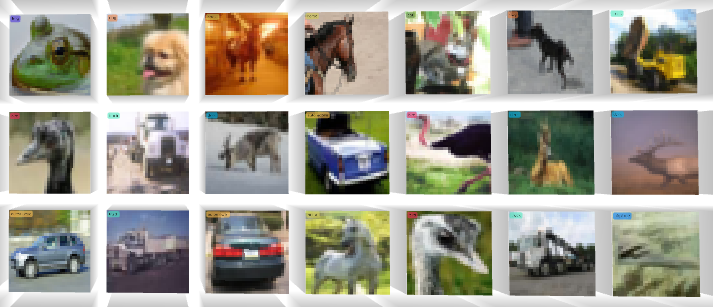

Load CIFAR-10 data from Hub

In [ ]:
%%black
#load CIFAR-10 dataset from HUB
ds_cifar10_hub = hub.load('hub://activeloop/cifar10-train')

Details about CIFAR-10 data

In [ ]:
%%black
ds_cifar10_hub # details about cifar10 data

Normalise the data

In [ ]:
%%black
# Normalise the data

def to_model_fit(item):
    x = item['images']/255 # normalize
    y = item['labels']
    return (x, y)


ds_cifar10_hub_tf = ds_cifar10_hub.tensorflow()
ds_cifar10_hub_tf = ds_cifar10_hub_tf.map(lambda x: to_model_fit(x))
ds_cifar10_hub_tf


# Batching and Shuffling Data

Shuffle entire dataset

In [ ]:
%%black
batch_size = 10

# shuffling on the entire dataset
shuffle_buffer = len(ds_cifar10_hub)

def visualize_img_label_in_first_batch_TF_ds(ds, batch_size):
  for image, label in ds:
    for b in range(batch_size):
      print(f'Image size: {image.numpy()[b].shape}')
      print(label.numpy()[b])
      plt.imshow(image.numpy()[b])
      plt.show()
    break



Shuffled batched data 

In [ ]:
%%black
ds_cifar10_hub_tf_shuffled_batched = ds_cifar10_hub_tf.shuffle(shuffle_buffer).batch(batch_size)

Visualize first batch in ds_cifar10_hub_tf_shuffled_batched

Image size: (32, 32, 3)
[9]


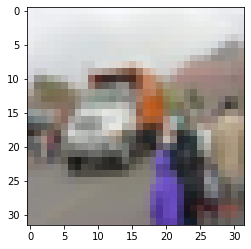

Image size: (32, 32, 3)
[5]


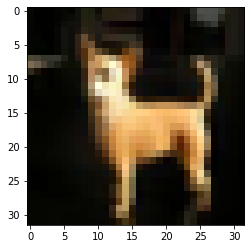

Image size: (32, 32, 3)
[3]


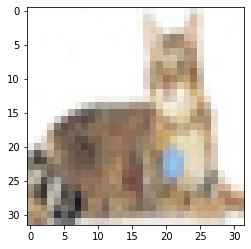

Image size: (32, 32, 3)
[2]


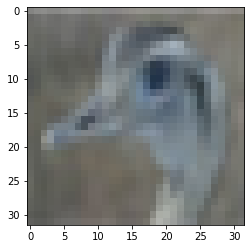

Image size: (32, 32, 3)
[8]


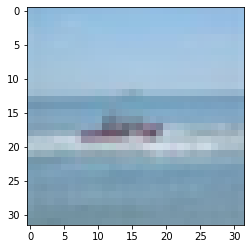

Image size: (32, 32, 3)
[3]


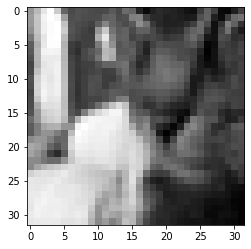

Image size: (32, 32, 3)
[6]


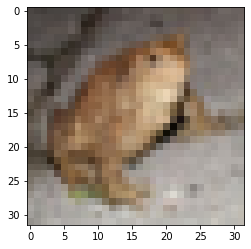

Image size: (32, 32, 3)
[5]


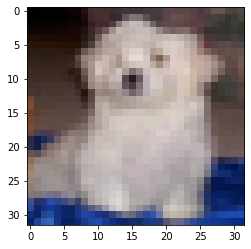

Image size: (32, 32, 3)
[2]


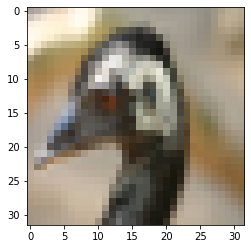

Image size: (32, 32, 3)
[7]


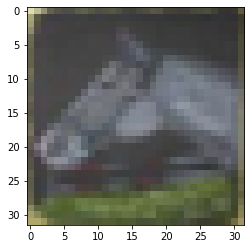

In [ ]:
%%black
visualize_img_label_in_first_batch_TF_ds(ds_cifar10_hub_tf_shuffled_batched, batch_size)

# Resizing CIFAR-10 to (28,28,3) using Hub transformation feature

Append the label and image to the output sample

In [ ]:
%%black
@hub.compute
def resize(sample_in, sample_out, new_size):    
    # Append the label and image to the output sample
    sample_out.labels.append(sample_in.labels.numpy())
    sample_out.images.append(np.array(Image.fromarray(sample_in.images.numpy()).resize(new_size)))
    
    return sample_out




visualize some of the images from the dataset

In [ ]:
%%black
def visualize_first_N_img_label_in_hub_ds(ds, number_images):
  N = 0
  for item in ds:
    if N <= number_images:
      print(f'Image size: {item.images.numpy().shape}')
      print(item.labels.numpy())
      plt.imshow(item.images.numpy())
      plt.show()
      N += 1
    else:
      break



Visualize first 4 images in ds_cifar10

Image size: (32, 32, 3)
[6]


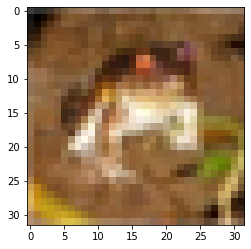

Image size: (32, 32, 3)
[9]


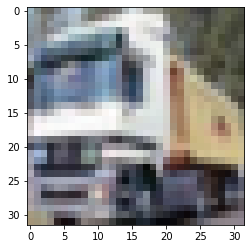

Image size: (32, 32, 3)
[9]


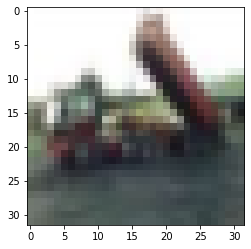

Image size: (32, 32, 3)
[4]


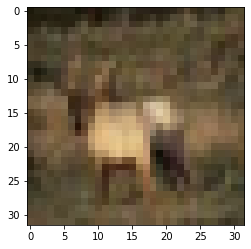

Image size: (32, 32, 3)
[1]


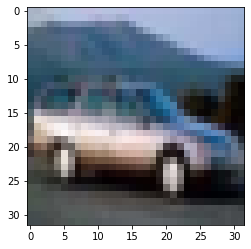

In [ ]:
%%black
# Visualize first 4 images in ds_cifar10
visualize_first_N_img_label_in_hub_ds(ds_cifar10_hub, 4)

list the resize measurement and seed

In [ ]:
%%black
resize_size = (28,28)

# We use the same seed to shuffle both the tf.data and Hub datasets so 
# that we can efficiently compare them
shuffle_common_seed = 21


Evaluate resize dataset

In [ ]:
%%black
# Hub path of new resized dataset -- this could be any path format (hub, s3, etc)
path_dataset_resized = './cifar10-dataset-resized-256x256'

# We use the overwrite=True to make this code re-runnable
ds_cifar10_hub_resized = hub.like(path_dataset_resized, ds_cifar10_hub, overwrite = True)

resize(new_size=resize_size).eval(ds_cifar10_hub, ds_cifar10_hub_resized, num_workers = 2)

Evaluating resize: 100%|██████████| 50000/50000 [14:00<00:00, 59.51it/s]


Normalize the data

In [ ]:
%%black
def to_model_fit(item):
    x = item['images']/255 # normalize
    y = item['labels']
    return (x, y)

Fit the model

In [ ]:
%%black
ds_cifar10_hub_tf = ds_cifar10_hub_resized.tensorflow()

ds_cifar10_hub_tf =  (ds_cifar10_hub_tf
                      # calling to_model_fit
                      .map(lambda x: to_model_fit(x))
                      .batch(batch_size)
                      .shuffle(len(ds_cifar10_hub_resized), seed=shuffle_common_seed)
                      .prefetch(tf.data.AUTOTUNE))


visualise the labeled data from batch

In [ ]:
%%black
visualize_img_label_in_first_batch_TF_ds(ds_cifar10_hub_tf, batch_size)

# Train the Model

In [ ]:
%%black
num_classes = 10
cifar10_class = ['airplane', 'automobile','bird','cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

compile the model

In [ ]:
%black
def train_with_simple_CNN_function(ds):
  model = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(resize_size[0], resize_size[1], 3)),
      tf.keras.layers.Conv2D(16,3,padding='same',activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32,3,padding='same',activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128,activation='relu'),
     tf.keras. layers.Dense(len(cifar10_class), activation='softmax')
  ])

  # Compile the model, we are using the Adam optimizer, the SparseCategoricalCrossentropy loss
  # and SparseCategoricalAccuracy because our labels are not categorical 
  model.compile(
      optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  # Start training over 2 epoch
  history = model.fit(ds, epochs = 2)
  model.summary()

call the training function and run iteration

In [ ]:
%%black
train_with_simple_CNN_function(ds_cifar10_hub_tf)